In [1]:
# %pip install tqdm
# %pip install python-dotenv
# %pip install torch==2.4.0+cu118
# %pip install scikit_learn==1.2.2
# %pip install ipython
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install tabulate
# %pip install scipy
# %pip install git+https://github.com/Louis-Li-dev/ML_tool_kit

In [2]:
import os
import sys
parent_dir = os.path.join(os.getcwd(), '..')
if parent_dir not in sys.path: sys.path.append(parent_dir)
from utility.data_utils import *
from utility.visuals import *
from dotenv import load_dotenv
from model.CNN import ConditionalSegmentationVAE
from mkit.torch_support.tensor_utils import xy_to_tensordataset
from torch import nn
from IPython.display import clear_output
from sklearn.ensemble import RandomForestRegressor
load_dotenv()
DATA_DIR = os.getenv("DATA_DIR")

- Dataset

In [3]:
if not os.path.exists(DATA_DIR): raise FileNotFoundError("Make sure the data directory is correctly placed.")

In [4]:
files = get_files(DATA_DIR)

return_list = []
file = files[0]
city_name = file.split('\\')[-1].split('.csv')[0].split('_')[0]

path_name = process_and_transform_data(file, resolution=.5, overwrite=True)
with open(path_name, 'rb') as f:
    result_dict = pickle.load(f)
labels = result_dict['labels']
encoder = result_dict['encoder']
MAX_LEN = result_dict['max length']
file_name = result_dict['file name']
WIDTH = result_dict['width']
HEIGHT = result_dict['height']

original dataset size: 238
dataset size with duplicates removed: 172


In [5]:
# for idx, label in enumerate(labels):
#     plt.imshow(labels[idx])
#     plt.savefig(f'../fig/{idx}_{file_name}.png')
#     plt.show()


- x y splitting

In [6]:
from sklearn.model_selection import train_test_split


unique_labels = [u for u in labels if np.array(np.where(u != 0)).T.shape[0] > 1]
padded_labels = []
for label in unique_labels:
    unique_vals = np.unique(label)[1:]
    new_vals = []
    count = 0
    for val in unique_vals:    
        dummy_vals = np.zeros(label.shape)
        dummy_vals[np.where(label == val)] = 1
        new_vals.append(dummy_vals)
        count += 1
    for i in range(count, MAX_LEN):
        dummy_vals = np.zeros(label.shape)
        new_vals.append(dummy_vals)
    new_vals = np.array(new_vals)
    padded_labels.append(new_vals)
train_labels, test_labels = train_test_split(padded_labels, test_size=.2)


In [7]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_channels, img_width, img_height, start_dim, n_layers, latent_dim):
        """
        Fully Connected Encoder.

        Args:
            input_channels (int): Number of input channels (here, max_len).
            img_width (int): Image width.
            img_height (int): Image height.
            start_dim (int): Size of the first hidden layer.
            n_layers (int): Number of hidden layers (each doubling the previous size).
            latent_dim (int): Size of the latent representation.
        """
        super(Encoder, self).__init__()
        # The input is flattened: (B, max_len, W, H) -> (B, max_len*W*H)
        input_size = input_channels * img_width * img_height
        layers = []
        # First layer: from flattened input to start_dim
        layers.append(nn.Linear(input_size, start_dim))
        layers.append(nn.Mish())
        hidden_dim = start_dim
        # Add n_layers that double the hidden size at each layer
        for _ in range(n_layers):
            next_dim = hidden_dim * 2
            layers.append(nn.Linear(hidden_dim, next_dim))
            layers.append(nn.Mish())
            hidden_dim = next_dim
        # Final layer: latent representation
        layers.append(nn.Linear(hidden_dim, latent_dim))
        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        # x is expected to have shape: (B, max_len, width, height)
        x = x.view(x.size(0), -1)  # Flatten to (B, max_len*width*height)
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, output_channels, img_width, img_height, start_dim, n_layers, latent_dim):
        """
        Fully Connected Decoder.

        Args:
            output_channels (int): Number of output channels (should match input_channels).
            img_width (int): Image width.
            img_height (int): Image height.
            start_dim (int): Should match the start_dim used in the encoder.
            n_layers (int): Number of hidden layers (used in encoder, in reverse order here).
            latent_dim (int): Size of the latent representation.
        """
        super(Decoder, self).__init__()
        # The output will be reshaped into (B, output_channels, img_width, img_height)
        output_size = output_channels * img_width * img_height
        layers = []
        # For symmetry, assume the encoder’s last hidden dimension was start_dim * (2 ** n_layers)
        hidden_dim = start_dim * (2 ** n_layers)
        # First layer: from latent_dim to hidden_dim
        layers.append(nn.Linear(latent_dim, hidden_dim))
        layers.append(nn.Mish())
        # Then, for each layer, halve the hidden dimension
        for _ in range(n_layers):
            next_dim = hidden_dim // 2
            layers.append(nn.Linear(hidden_dim, next_dim))
            layers.append(nn.Mish())
            hidden_dim = next_dim
        # Final layer: output layer to reconstruct the flattened image
        layers.append(nn.Linear(hidden_dim, output_size))
        layers.append(nn.Sigmoid())  # Ensures the output values are between 0 and 1
        self.decoder = nn.Sequential(*layers)
        self.output_channels = output_channels
        self.img_width = img_width
        self.img_height = img_height

    def forward(self, z):
        x = self.decoder(z)
        # Reshape back to image dimensions: (B, output_channels, img_width, img_height)
        x = x.view(x.size(0), self.output_channels, self.img_width, self.img_height)
        return x

class Autoencoder(nn.Module):
    def __init__(self, input_channels, img_width, img_height, start_dim, n_layers, latent_dim, output_channels):
        """
        Fully Connected Autoencoder (combining the encoder and decoder).

        Args:
            input_channels (int): Number of input channels (here, max_len).
            img_width (int): Image width.
            img_height (int): Image height.
            start_dim (int): The size of the first hidden layer.
            n_layers (int): Number of hidden layers.
            latent_dim (int): Size of the latent representation.
            output_channels (int): Number of output channels (should match input_channels).
        """
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_channels, img_width, img_height, start_dim, n_layers, latent_dim)
        self.decoder = Decoder(output_channels, img_width, img_height, start_dim, n_layers, latent_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def generate(input_channels, img_width, img_height, start_dim, n_layers, latent_dim, output_channels, device="cpu", output_type="autoencoder"):
    """
    Creates an encoder, decoder, or autoencoder model based on user input.

    Args:
        input_channels (int): Number of input channels (here, max_len).
        img_width (int): Image width.
        img_height (int): Image height.
        start_dim (int): The size of the first hidden layer.
        n_layers (int): Number of hidden layers (each doubling the dimension in the encoder).
        latent_dim (int): Size of the latent representation.
        output_channels (int): Number of output channels (should match input_channels).
        device (str): 'cpu' or 'cuda'.
        output_type (str): 'encoder', 'decoder', or 'autoencoder'.

    Returns:
        A PyTorch model on the selected device.
    """
    device = torch.device(device)
    if output_type == "encoder":
        model = Encoder(input_channels, img_width, img_height, start_dim, n_layers, latent_dim)
    elif output_type == "decoder":
        model = Decoder(output_channels, img_width, img_height, start_dim, n_layers, latent_dim)
    elif output_type == "autoencoder":
        model = Autoencoder(input_channels, img_width, img_height, start_dim, n_layers, latent_dim, output_channels)
    else:
        raise ValueError("Invalid output_type. Choose from 'encoder', 'decoder', or 'autoencoder'.")
    return model.to(device)


- data processing

In [8]:

loader, val_loader = xy_to_tensordataset(
    train_labels, train_labels,
    return_loader=True, 
    batch_size=8,
    input_dtype=torch.float32,
    output_dtype=torch.float32,
    val_ratio=.15,
)

c:\Users\ss348\anaconda3\Lib\site-packages\mkit\torch_support\tensor_utils.py:438: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return torch.tensor(arr)


In [9]:
from mkit.torch_support.nn_utils import training_loop
model = Autoencoder(MAX_LEN, WIDTH, HEIGHT, start_dim=128, n_layers=3, latent_dim=1000, output_channels=MAX_LEN)
training_loop(
    model, 
    train_loader=loader,
    val_loader=val_loader,
    optimizer=torch.optim.Adamax(model.parameters()),
    criterion=nn.BCELoss(),
    device=torch.device('cuda'),
    epochs=100,
    early_stopping=True
)

EPOCH 1/100: 100%|██████████| 15/15 [00:00<00:00, 20.57it/s]


Epoch [1/100] Training Loss: 0.3911  Validation Loss: 0.0637



EPOCH 2/100: 100%|██████████| 15/15 [00:00<00:00, 43.26it/s]


Epoch [2/100] Training Loss: 0.0136  Validation Loss: 0.0019



EPOCH 3/100: 100%|██████████| 15/15 [00:00<00:00, 48.20it/s]


Epoch [3/100] Training Loss: 0.0014  Validation Loss: 0.0015



EPOCH 4/100: 100%|██████████| 15/15 [00:00<00:00, 52.95it/s]


Epoch [4/100] Training Loss: 0.0010  Validation Loss: 0.0013



EPOCH 5/100: 100%|██████████| 15/15 [00:00<00:00, 62.53it/s]


Epoch [5/100] Training Loss: 0.0008  Validation Loss: 0.0011



EPOCH 6/100: 100%|██████████| 15/15 [00:00<00:00, 61.77it/s]


Epoch [6/100] Training Loss: 0.0007  Validation Loss: 0.0010



EPOCH 7/100: 100%|██████████| 15/15 [00:00<00:00, 60.36it/s]


Epoch [7/100] Training Loss: 0.0006  Validation Loss: 0.0010



EPOCH 8/100: 100%|██████████| 15/15 [00:00<00:00, 62.19it/s]


Epoch [8/100] Training Loss: 0.0007  Validation Loss: 0.0009



EPOCH 9/100: 100%|██████████| 15/15 [00:00<00:00, 65.34it/s]


Epoch [9/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 10/100: 100%|██████████| 15/15 [00:00<00:00, 64.89it/s]


Epoch [10/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 11/100: 100%|██████████| 15/15 [00:00<00:00, 67.42it/s]


Epoch [11/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 12/100: 100%|██████████| 15/15 [00:00<00:00, 61.70it/s]


Epoch [12/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 13/100: 100%|██████████| 15/15 [00:00<00:00, 67.14it/s]


Epoch [13/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 14/100: 100%|██████████| 15/15 [00:00<00:00, 73.49it/s]


Epoch [14/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 15/100: 100%|██████████| 15/15 [00:00<00:00, 72.25it/s]


Epoch [15/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 16/100: 100%|██████████| 15/15 [00:00<00:00, 67.49it/s]


Epoch [16/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 17/100: 100%|██████████| 15/15 [00:00<00:00, 60.27it/s]


Epoch [17/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 18/100: 100%|██████████| 15/15 [00:00<00:00, 67.28it/s]


Epoch [18/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 19/100: 100%|██████████| 15/15 [00:00<00:00, 66.01it/s]


Epoch [19/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 20/100: 100%|██████████| 15/15 [00:00<00:00, 67.08it/s]


Epoch [20/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 21/100: 100%|██████████| 15/15 [00:00<00:00, 63.61it/s]


Epoch [21/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 22/100: 100%|██████████| 15/15 [00:00<00:00, 62.91it/s]


Epoch [22/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 23/100: 100%|██████████| 15/15 [00:00<00:00, 66.29it/s]


Epoch [23/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 24/100: 100%|██████████| 15/15 [00:00<00:00, 58.42it/s]


Epoch [24/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 25/100: 100%|██████████| 15/15 [00:00<00:00, 49.88it/s]


Epoch [25/100] Training Loss: 0.0005  Validation Loss: 0.0009



EPOCH 26/100: 100%|██████████| 15/15 [00:00<00:00, 44.49it/s]


Epoch [26/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 27/100: 100%|██████████| 15/15 [00:00<00:00, 50.73it/s]


Epoch [27/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 28/100: 100%|██████████| 15/15 [00:00<00:00, 51.34it/s]


Epoch [28/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 29/100: 100%|██████████| 15/15 [00:00<00:00, 59.81it/s]


Epoch [29/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 30/100: 100%|██████████| 15/15 [00:00<00:00, 63.08it/s]


Epoch [30/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 31/100: 100%|██████████| 15/15 [00:00<00:00, 61.70it/s]


Epoch [31/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 32/100: 100%|██████████| 15/15 [00:00<00:00, 64.46it/s]


Epoch [32/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 33/100: 100%|██████████| 15/15 [00:00<00:00, 58.41it/s]


Epoch [33/100] Training Loss: 0.0006  Validation Loss: 0.0008



EPOCH 34/100: 100%|██████████| 15/15 [00:00<00:00, 56.31it/s]


Epoch [34/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 35/100: 100%|██████████| 15/15 [00:00<00:00, 54.74it/s]


Epoch [35/100] Training Loss: 0.0006  Validation Loss: 0.0008



EPOCH 36/100: 100%|██████████| 15/15 [00:00<00:00, 60.61it/s]


Epoch [36/100] Training Loss: 0.0005  Validation Loss: 0.0009



EPOCH 37/100: 100%|██████████| 15/15 [00:00<00:00, 64.40it/s]


Epoch [37/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 38/100: 100%|██████████| 15/15 [00:00<00:00, 58.57it/s]


Epoch [38/100] Training Loss: 0.0006  Validation Loss: 0.0008



EPOCH 39/100: 100%|██████████| 15/15 [00:00<00:00, 57.22it/s]


Epoch [39/100] Training Loss: 0.0006  Validation Loss: 0.0008



EPOCH 40/100: 100%|██████████| 15/15 [00:00<00:00, 60.74it/s]


Epoch [40/100] Training Loss: 0.0005  Validation Loss: 0.0008



EPOCH 41/100: 100%|██████████| 15/15 [00:00<00:00, 44.26it/s]


Epoch [41/100] Training Loss: 0.0006  Validation Loss: 0.0008



EPOCH 42/100: 100%|██████████| 15/15 [00:00<00:00, 57.94it/s]


Epoch [42/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 43/100: 100%|██████████| 15/15 [00:00<00:00, 57.59it/s]


Epoch [43/100] Training Loss: 0.0006  Validation Loss: 0.0009



EPOCH 44/100: 100%|██████████| 15/15 [00:00<00:00, 61.58it/s]


Epoch [44/100] Training Loss: 0.0005  Validation Loss: 0.0008



EPOCH 45/100: 100%|██████████| 15/15 [00:00<00:00, 57.95it/s]


Epoch [45/100] Training Loss: 0.0005  Validation Loss: 0.0008



EPOCH 46/100: 100%|██████████| 15/15 [00:00<00:00, 53.98it/s]


Epoch [46/100] Training Loss: 0.0006  Validation Loss: 0.0008



EPOCH 47/100: 100%|██████████| 15/15 [00:00<00:00, 56.92it/s]


Epoch [47/100] Training Loss: 0.0005  Validation Loss: 0.0008



EPOCH 48/100: 100%|██████████| 15/15 [00:00<00:00, 61.12it/s]


Epoch [48/100] Training Loss: 0.0006  Validation Loss: 0.0008



EPOCH 49/100: 100%|██████████| 15/15 [00:00<00:00, 57.33it/s]


Epoch [49/100] Training Loss: 0.0005  Validation Loss: 0.0008



EPOCH 50/100: 100%|██████████| 15/15 [00:00<00:00, 50.40it/s]


Epoch [50/100] Training Loss: 0.0005  Validation Loss: 0.0009



EPOCH 51/100: 100%|██████████| 15/15 [00:00<00:00, 61.17it/s]

Epoch [51/100] Training Loss: 0.0006  Validation Loss: 0.0008

Training stopped after 6 consecutive iterations without improvement.
Training completed.
Best validation loss: 0.0008362308338594934, model loaded with the selected parameters


Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=21504, out_features=128, bias=True)
      (1): Mish()
      (2): Linear(in_features=128, out_features=256, bias=True)
      (3): Mish()
      (4): Linear(in_features=256, out_features=512, bias=True)
      (5): Mish()
      (6): Linear(in_features=512, out_features=1024, bias=True)
      (7): Mish()
      (8): Linear(in_features=1024, out_features=1000, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=1000, out_features=1024, bias=True)
      (1): Mish()
      (2): Linear(in_features=1024, out_features=512, bias=True)
      (3): Mish()
      (4): Linear(in_features=512, out_features=256, bias=True)
      (5): Mish()
      (6): Linear(in_features=256, out_features=128, bias=True)
      (7): Mish()
      (8): Linear(in_features=128, out_features=21504, bias=True)
      (9): Sigmoid()
    )
  )
)

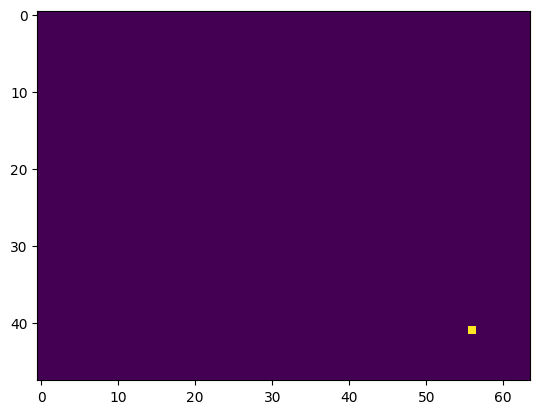

In [10]:
plt.imshow(test_labels[1][0])

In [11]:
pred = model(torch.tensor(test_labels, dtype=torch.float32, device=torch.device('cuda')))


In [12]:
import os
import matplotlib.pyplot as plt

idx = 1
for count, (pred_img, label_img) in enumerate(zip(pred[idx].cpu().detach(), test_labels[idx])):
    # Create a figure with 1 row and 2 columns, and set an appropriate figure size
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot prediction image with a title and a shrunken colorbar with some padding
    im0 = axes[0].imshow(pred_img, cmap='viridis')
    axes[0].set_title("Prediction")
    fig.colorbar(im0, ax=axes[0], shrink=0.7, pad=0.05)
    
    # Plot ground truth image with a title and a shrunken colorbar with some padding
    im1 = axes[1].imshow(label_img, cmap='viridis')
    axes[1].set_title("Ground Truth")
    fig.colorbar(im1, ax=axes[1], shrink=0.7, pad=0.05)
    
    # Adjust layout to leave space for the suptitle
    fig.subplots_adjust(top=0.85)
    NAME = f"Autoencoder_{count}_sigmoid_FullyConnected"
    fig.suptitle(NAME, fontsize=16)
    
    # Create output directory if it doesn't exist
    PATH = f'../fig/AE_SIGMOID/{idx}'
    os.makedirs(PATH, exist_ok=True)
    
    # Save and close the figure
    plt.savefig(f"{PATH}/{NAME}.png")
    plt.close(fig)


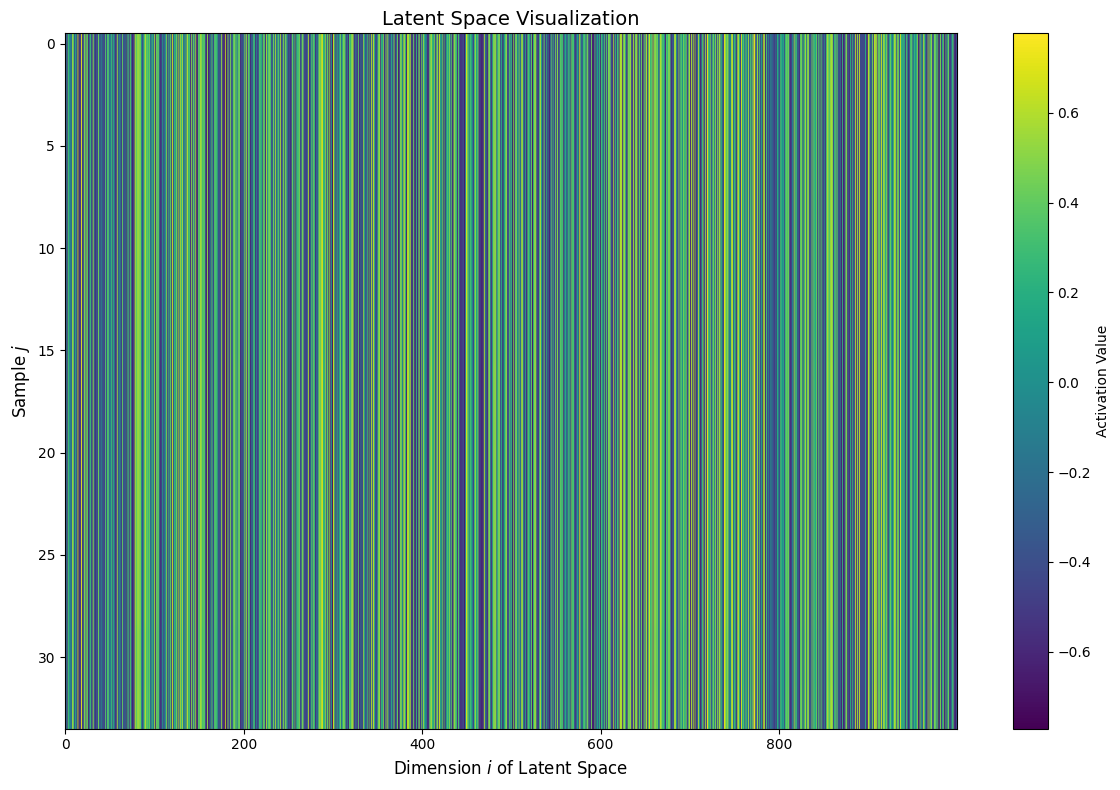

In [13]:


# Compute the latent representation from the test labels
latent = model.encoder(
    torch.tensor(test_labels, dtype=torch.float32, device=torch.device('cuda'))
).detach().cpu().numpy()

# Create a figure with a suitable size
plt.figure(figsize=(12, 8))

# Display the latent space matrix
im = plt.imshow(latent, aspect='auto', cmap='viridis')

# Add labels, title, and a colorbar for reference
plt.xlabel(r'Dimension $i$ of Latent Space', fontsize=12)
plt.ylabel(r'Sample $j$', fontsize=12)
plt.title("Latent Space Visualization", fontsize=14)
plt.colorbar(im, label='Activation Value')

# Adjust layout to prevent clipping of labels and title
plt.tight_layout()
plt.show()
